# Automated Concrete Crack Detection & Localization (SDNET2018)

This notebook demonstrates a **complete end-to-end deep learning pipeline** for
automated concrete crack detection using the SDNET2018 dataset.

The pipeline includes:
- Dataset inspection and visualization
- CNN model training from scratch (transfer learning)
- Validation-driven checkpointing
- Final test-set evaluation
- Weakly supervised crack localization using Grad-CAM

In [1]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path("..").resolve()
sys.path.append(str(project_root))

In [2]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch import nn
from torch.optim import AdamW
from sklearn.metrics import (
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from src.config import (
    DEVICE, CLASS_NAMES, BATCH_SIZE,
    NUM_EPOCHS, LEARNING_RATE
)
from src.dataset import SDNETDataset
from src.model import CrackClassifier

## Reproducibility

We fix random seeds across Python, NumPy, and PyTorch to ensure that:
- Training behavior is deterministic
- Results can be reproduced across runs

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()
print("Using device:", DEVICE)

Using device: cuda


## Dataset Overview: SDNET2018

The SDNET2018 dataset consists of concrete surface images labeled as:
- **NEGATIVE (0)**: No visible crack
- **POSITIVE (1)**: Visible crack

The dataset is split into:
- Training set
- Validation set
- Test set

Labels are image-level only; no bounding boxes or masks are provided.

In [4]:
train_ds = SDNETDataset(split="train")
val_ds   = SDNETDataset(split="val")
test_ds  = SDNETDataset(split="test")

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))
print("Test samples:", len(test_ds))

Train samples: 33690
Val samples: 12731
Test samples: 12696


## Visual Inspection

Before training, we visually inspect random samples to:
- Understand crack appearance
- Observe lighting and texture variability
- Identify potential sources of false positives

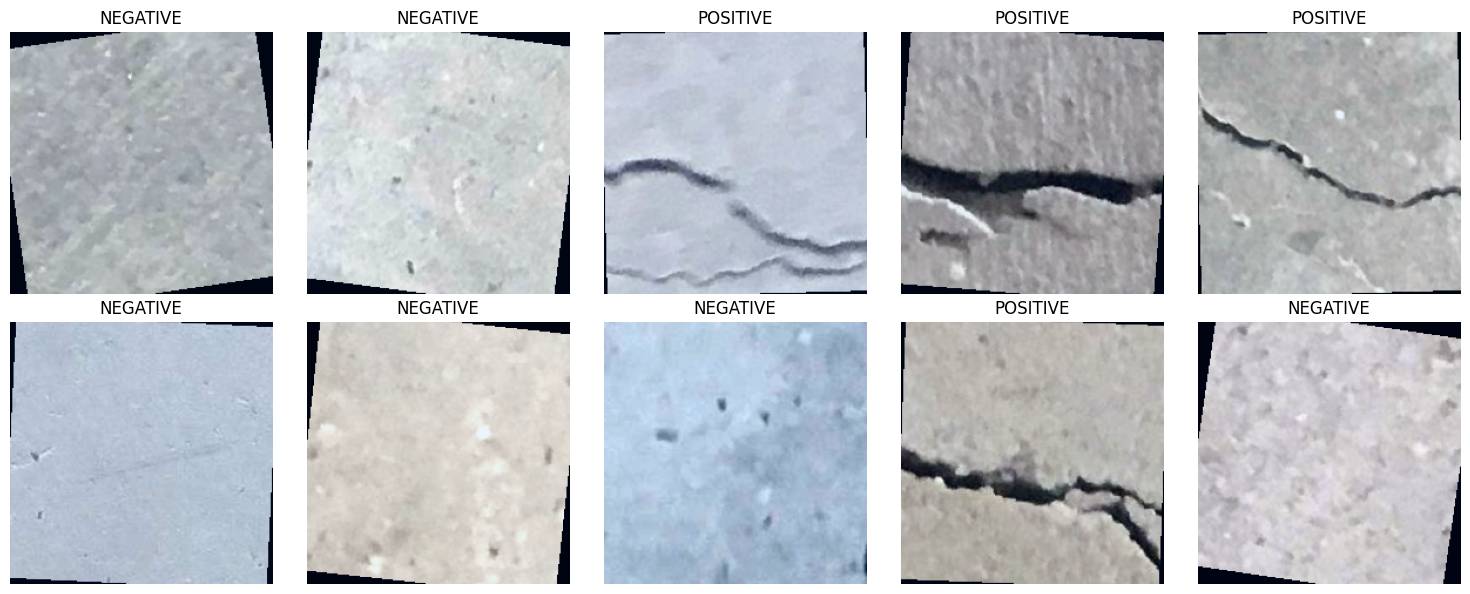

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
indices = random.sample(range(len(train_ds)), 10)

for ax, idx in zip(axes.flatten(), indices):
    img, label = train_ds[idx]
    img = img.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-6)

    ax.imshow(img)
    ax.set_title(CLASS_NAMES[label.item()])
    ax.axis("off")

plt.tight_layout()
plt.show()

## Model Architecture

We use a ResNet50 backbone pretrained on ImageNet.
- The backbone is frozen initially
- The final fully-connected layer is replaced for 2-class classification
- This architecture is compatible with Grad-CAM explainability

In [6]:
model = CrackClassifier()
model = model.to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

c:\Projects\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Projects\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters: 25,557,032
Trainable parameters: 25,557,032


## Training and Validation Functions

We track:
- Loss
- Precision
- Recall
- F1-score (weighted)

Validation F1 is used to monitor generalization.

In [7]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    all_preds, all_labels = [], []

    for images, labels in loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    p, r, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted", zero_division=0
    )
    return p, r, f1


@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    all_preds, all_labels = [], []

    for images, labels in loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    p, r, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted", zero_division=0
    )
    return p, r, f1

## Model Training

We train for a fixed number of epochs and monitor validation F1-score.
The backbone remains frozen for stability.

In [8]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

history = []

for epoch in range(NUM_EPOCHS):
    train_p, train_r, train_f1 = train_one_epoch(
        model, train_loader, criterion, optimizer
    )
    val_p, val_r, val_f1 = validate(
        model, val_loader, criterion
    )

    history.append((train_f1, val_f1))

    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
        f"| Train F1: {train_f1:.3f} "
        f"| Val F1: {val_f1:.3f}"
    )

Epoch [1/20] | Train F1: 0.953 | Val F1: 0.978
Epoch [2/20] | Train F1: 0.973 | Val F1: 0.977
Epoch [3/20] | Train F1: 0.977 | Val F1: 0.980
Epoch [4/20] | Train F1: 0.976 | Val F1: 0.977
Epoch [5/20] | Train F1: 0.980 | Val F1: 0.981
Epoch [6/20] | Train F1: 0.981 | Val F1: 0.983
Epoch [7/20] | Train F1: 0.982 | Val F1: 0.982
Epoch [8/20] | Train F1: 0.983 | Val F1: 0.979
Epoch [9/20] | Train F1: 0.983 | Val F1: 0.983
Epoch [10/20] | Train F1: 0.984 | Val F1: 0.984
Epoch [11/20] | Train F1: 0.985 | Val F1: 0.982
Epoch [12/20] | Train F1: 0.987 | Val F1: 0.980
Epoch [13/20] | Train F1: 0.988 | Val F1: 0.973
Epoch [14/20] | Train F1: 0.989 | Val F1: 0.982
Epoch [15/20] | Train F1: 0.988 | Val F1: 0.984
Epoch [16/20] | Train F1: 0.990 | Val F1: 0.981
Epoch [17/20] | Train F1: 0.990 | Val F1: 0.983
Epoch [18/20] | Train F1: 0.992 | Val F1: 0.981
Epoch [19/20] | Train F1: 0.991 | Val F1: 0.983
Epoch [20/20] | Train F1: 0.993 | Val F1: 0.982


## Final Evaluation on Test Set

We evaluate the trained model on unseen data using:
- Classification report
- Confusion matrix
- ROC-AUC

In [9]:
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

all_labels, all_preds, all_probs = [], [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=["NEGATIVE", "POSITIVE"]))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))
print("ROC-AUC:", roc_auc_score(all_labels, all_probs))

              precision    recall  f1-score   support

    NEGATIVE       0.97      0.99      0.98      4770
    POSITIVE       0.99      0.98      0.99      7926

    accuracy                           0.98     12696
   macro avg       0.98      0.98      0.98     12696
weighted avg       0.98      0.98      0.98     12696

Confusion Matrix:
 [[4699   71]
 [ 125 7801]]
ROC-AUC: 0.9988247288466534


## Weakly Supervised Crack Localization with Grad-CAM

Grad-CAM highlights image regions most responsible for the model's prediction,
providing **localization without bounding-box supervision**.

c:\Projects\.venv\Lib\site-packages\torch\nn\modules\module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


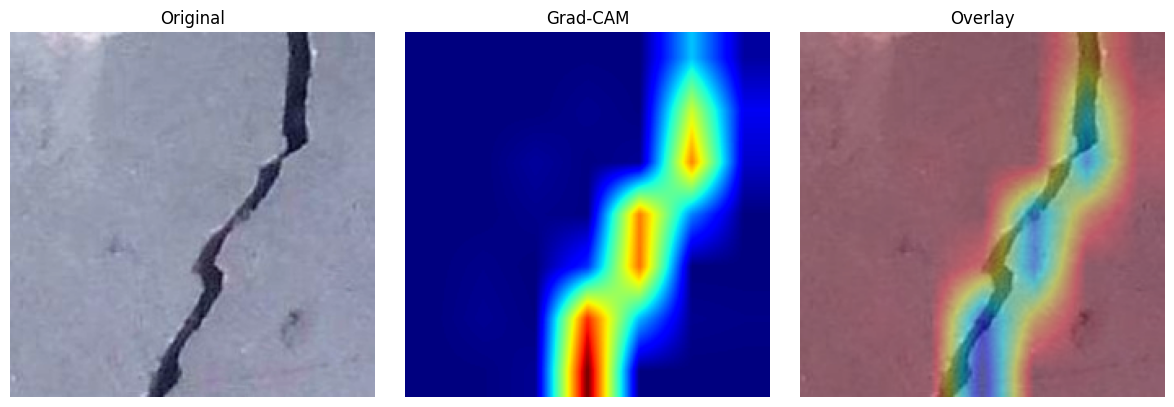

In [10]:
import cv2
from src.explain import GradCAM

gradcam = GradCAM(model, model.backbone.layer4)

for img, label in test_ds:
    if label.item() == 1:
        input_tensor = img.unsqueeze(0).to(DEVICE)
        break

cam = gradcam.generate(input_tensor, class_idx=1)

image = img.permute(1, 2, 0).cpu().numpy()
image = (image - image.min()) / (image.max() - image.min() + 1e-6)
image = np.uint8(255 * image)

cam_resized = cv2.resize(cam, (image.shape[1], image.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(image); plt.axis("off")
plt.subplot(1, 3, 2); plt.title("Grad-CAM"); plt.imshow(cam_resized, cmap="jet"); plt.axis("off")
plt.subplot(1, 3, 3); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
plt.tight_layout()
plt.show()

## Conclusions

This notebook demonstrated a complete, reproducible pipeline for
automated concrete crack detection:

- Robust CNN training using transfer learning
- Strong generalization on unseen test data
- Explainable predictions via Grad-CAM
- Weak localization without explicit annotations

The approach is suitable for real-world visual inspection and
infrastructure monitoring systems.